# Dynamic Programming
Notes taken from: "Reinforcement Learning" by Richard S. Sutton and Andrew G. Barto <br>
Link: http://www.incompleteideas.net/book/the-book.html 

>Dynamic programming (DP) are a collection of algorithms that can computer the optimal policies for a perfectly modeled Markov Decision Process (MDP)
<br>
Howeve, they tend to be expensive. So many of the reinforcement learning methods are approximations.

Since we are working with DPs, we will assume that our problems in this section are perfect MDPs. And we will use DPs to approximate the value functions for these MDPs. Once the value functions are established it is easy to use them to find the optimal policies

**Note:** In a very general sense, DP algorithms are obtained by turning Bellman equations into assigments with update values.

## Policy Evaluation (Prediction)

**policy evaluation / prediction problem** - how to compute the state-value function $v_\pi$ for some arbritrary polict $\pi$ 
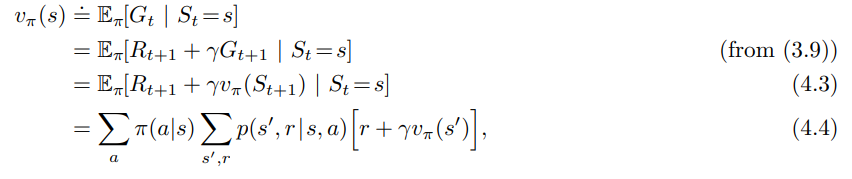
If the environment's dynamics are known then equation 4.4 can become a system of linear equations with as many unknowns as possible states (because each $v_\pi(s_i)$ is an unknown)
<br>
However, solving it with linear algebra is to expensive, so we explore an iterative solution instead.

### Iterative solution
First define an arbritrary state-value mapping $v_0$ that maps from $S^+$ to a real number. The only rule is that terminal states map to 0. Then just iterate over it and redifine a new state-value mapping $v_{k+1}$ such that:
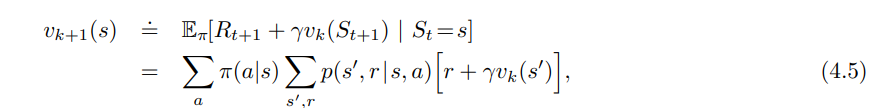
Using the policy decision mapping for whatever $\pi$ we are calculating the state-value mapping for. Eventually $V_k$ will converge to $v_\pi$
<br>
This iterative solution can be implemented as an in-place algorithm and can converge quickly!
**Exercise:** Impliment this

## Value Iteration

## Policy Improvement
The **policy improvement theorem** basically outlines that a better policy $\pi'$ can be found if for a state $s_i$ an action $a_k$ that is not $\pi(a|s)$ has a higher value.<br>
In other words:<br>
$$q_\pi(a_k,s) >= q_\pi(\pi(a|s), s)$$
where $a_k \neq \pi(a|s)$ <br>

## Policy Iteration

In DP, policy iteration is basically repeating the above policy improvement theorem over again until an equilibrium is reached.
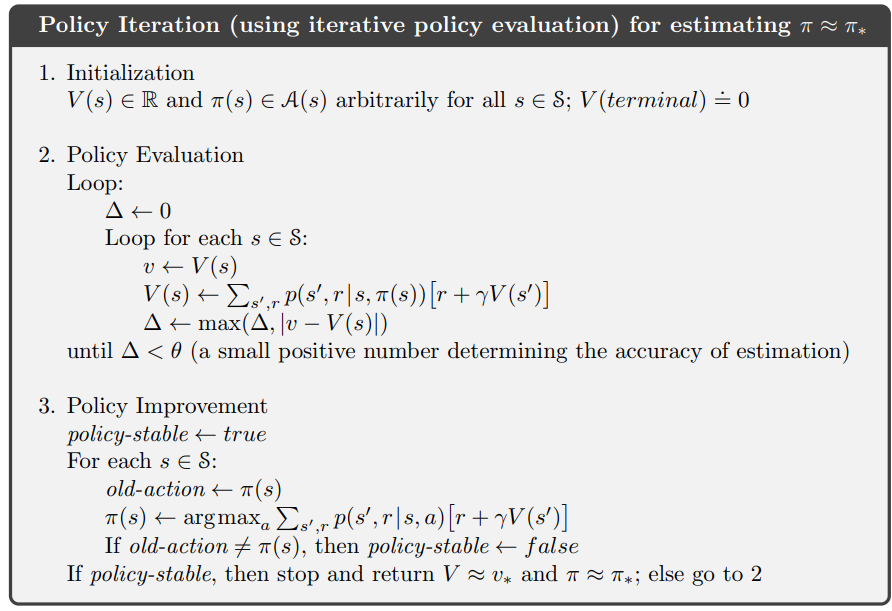
Policy iteration actually tends to converge rather quickly, can can be used to solve some cool leetcode problems.<br>
**Leet code example**

Things to notice: changing where the player gets transported to can change the end value of the "absorbing" states.

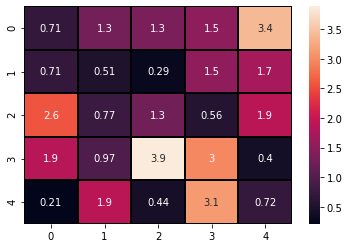

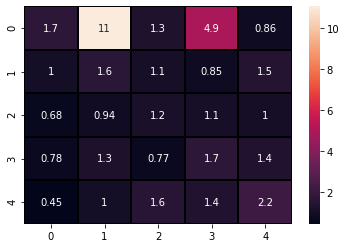

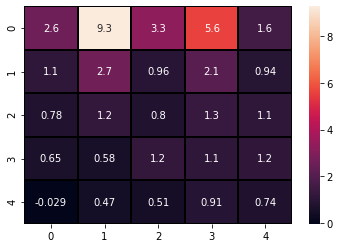

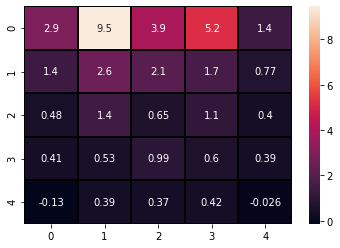

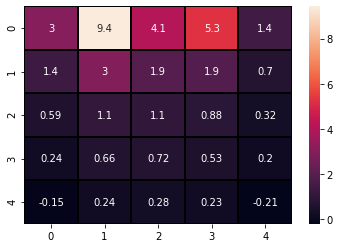

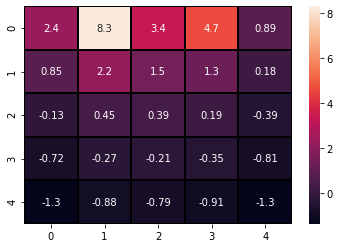

In [3]:
# MIT License

# Copyright (c) 2020 Eduardo Pignatelli

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap
from heapq import heappop, heappush, heapify

W = LinearSegmentedColormap.from_list('w', ["w", "w"], N=256)

ACTIONS = {
    0: [1, 0],   # north
    1: [-1, 0],  # south
    2: [0, -1],  # west
    3: [0, 1],   # east
}


class GridWorld:
    def __init__(self, size=4):
        """
        A gridworld environment with absorbing states at [0, 0] and [size - 1, size - 1].
        Args:
            size (int): the dimension of the grid in each direction
            cell_reward (float): the reward return after extiting any non absorbing state
        """
        self.size = size
        self.absorbStates = {(0, 1) : ((4, 1), 10),
                             (0, 3) : ((2, 3), 5)}
#         self.state_value = np.ones((size, size))
        self.state_value = np.random.rand(size, size)*4
        return

    def step(self, state, action):
        # is terminal state? good job        
        if state in self.absorbStates.keys():
#             return state, 1   this would create an infinite value problem (just stay in place)
#             maybe returning at all causes infinite value? if you return then its not really absorbing?
            
            return self.absorbStates[state][0], self.absorbStates[state][1]
        #calculate new state
        s_1 = (state[0] + action[0], state[1] + action[1])
        #if new state out of bound then don't move and PUNISH
        if self.isOutofBounds(s_1):
            return state, -1
        #otherwise just move and give 0 reward
        return s_1, 0

    def isOutofBounds(self, state):
        return state[0] < 0 or state[0] >= self.size or state[1] < 0 or state[1] >= self.size
        
    def render(self):
        """
        Displays the current value table of mini gridworld environment
        """
        sn.heatmap(self.state_value, annot=True, linewidths=1, linecolor="black")
        plt.show()

    def bellman_expectation(self, state, probs, discount):
        """
        Makes a one step lookahead and applies the bellman expectation equation to the state self.state_value[state]
        Args:
            state (Tuple[int, int]): the x, y indices that define the address on the value table
            probs (List[float]): transition probabilities for each action
        Returns:
            (numpy.ndarrray): the new value for the specified state
        """
        # absorbing state
        value = 0
        for c, action in ACTIONS.items():
            s_1, reward = self.step(state, action)
            value += probs[c] * (reward + discount * self.state_value[s_1])
        return value, probs


def policy_evaluation(env, policy=None, steps=1, discount=.9, in_place=False):
    """
    Args:
        policy (numpy.array): a numpy 3-D numpy array, where the first two dimensions identify a state and the third dimension identifies the actions.
                              The array stores the probability of taking each action.
        steps (int): the number of iterations of the algorithm
        discount (float): discount factor for the bellman equations
        in_place (bool): if False, the value table is updated after all the new values have been calculated.
             if True the state [i, j] will new already new values for the states [< i, < j]
    """
    if policy is None:
        # uniform random policy
        policy = np.ones((*env.state_value.shape, len(ACTIONS))) * 0.25

    for k in range(steps):
        # cache old values if not in place
        values = env.state_value if in_place else np.empty_like(
            env.state_value)
        for i in range(len(env.state_value)):
            for j in range(len(env.state_value[i])):
                # apply bellman expectation equation to each state
                state = (i, j)
                value, _ = env.bellman_expectation(state, policy[i, j], discount)
                values[i, j] = value * discount
        # set the new value table
        env.state_value = values
    return env.state_value


if __name__ == "__main__":
    # reprocuce Figure 4.1
    for k in [0, 1, 2, 3, 4, 1000]:
        env = GridWorld(5)
#         env.render()
        value_table = policy_evaluation(env, steps=k, in_place=False)
        env.render()

## Asynchronous Dynamic Programming
The book mentions that in some big problems the set of states is way to large and doing a wholistic sweep of all states to update their values takes too long. It suggests that an asynchronous strategy can be used where the values of some states which have a big impact on changing the policy can be updated more frequently. However, the book doesn't really provide hard info.